In [38]:
# Imports all the required packages
import os
import argparse
import numpy as np
import os.path as osp
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.data import (InMemoryDataset, download_url, extract_zip,Data)

import torch
#from torcheval.metrics import R2Score # To be implemented
import torch.nn as nn
import torch.nn.functional as F
from rdkit.Chem import DataStructs
from torch_geometric.loader import DataLoader

import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.optim as optim
from torch_geometric.nn import GCNConv,GraphConv
from torch_geometric.nn import global_add_pool

try:
    import rdkit
    from rdkit import Chem
    from rdkit.Chem import AllChem
    from rdkit import rdBase
    from rdkit.Chem.rdchem import HybridizationType
    from rdkit import RDConfig
    from rdkit.Chem import ChemicalFeatures
    from rdkit.Chem.rdchem import BondType as BT
    from rdkit.Chem import Draw
    rdBase.DisableLog('rdApp.error')
except ImportError:
    print("rdkit = None")

In [39]:
# Model definition used for regression

class GCNlayer(nn.Module):
    
    def __init__(self, n_features, conv_dims, concat_dim, dropout):
        super(GCNlayer, self).__init__()
        self.n_features = n_features
        self.conv_dims = conv_dims
        self.concat_dim =  concat_dim
        self.dropout = dropout
        
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        
        # args.conv_dims=[args.n_features,128,512,4092]
        for i in range(len(self.conv_dims)-1):
            conv = GraphConv(self.conv_dims[i], self.conv_dims[i+1],depth=i+1)
            self.convs.append(conv)
            bn = BatchNorm1d(self.conv_dims[i+1])
            self.bns.append(bn)
        self.conv_last = GraphConv(self.conv_dims[-1], self.concat_dim,depth=3)  # Last layer
        self.bn_last = BatchNorm1d(self.concat_dim)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for i in range(len(self.convs)):
            x = F.relu(self.convs[i](x, edge_index))
            x = self.bns[i](x)
        x = F.relu(self.conv_last(x, edge_index))
        x = self.bn_last(x)
        x = global_add_pool(x, data.batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x
    
class FClayer(nn.Module):
    
    def __init__(self, concat_dim, pred_dims, out_dim, dropout):
        super(FClayer, self).__init__()
        self.concat_dim = concat_dim
        self.pred_dims = pred_dims
        self.out_dim = out_dim
        self.dropout = dropout

        self.fcs = nn.ModuleList()
        self.bns = nn.ModuleList()
        # Linear layer has bias default=True
        for i in range(len(self.pred_dims)-1):
            fc = Linear(self.pred_dims[i], self.pred_dims[i+1])
            self.fcs.append(fc)
            bn = BatchNorm1d(self.pred_dims[i+1])
            self.bns.append(bn)
        self.fc_last = Linear(self.pred_dims[-1], self.out_dim)
    
    def forward(self, data):
        x = data
        for i in range(len(self.fcs)):
            x = F.relu(self.fcs[i](x))
            x = self.bns[i](x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc_last(x)
        return x

# Model definition  
class GCN_Model_reg(nn.Module):
    def __init__(self, args):
        super(GCN_Model_reg, self).__init__()
        
        # Convolutional Layer call
        self.conv = GCNlayer(args.n_features,args.conv_dims,args.concat_dim,args.dropout)

        # Fully connected layer call
        self.fc = FClayer(args.concat_dim,args.pred_dims,args.out_dim,args.dropout)
        
    def forward(self, data):
        x = self.conv(data) # Calling the convolutional layercpu
        x = self.fc(x) # Calling the Fully Connected Layer
        return x

In [40]:
# pytorch will be run on cpu
seed=200
paser = argparse.ArgumentParser()
args = paser.parse_args("")
np.random.seed(200)
torch.manual_seed(seed)
device=input("Enter cuda or cpu for device type")
device = torch.device(device)
#'cuda' if torch.cuda.is_available() else
device

device(type='cuda')

In [41]:
# Inputs required by the program
args.epoch = 300
args.lr = 0.0001
args.optim = 'Adam'
args.step_size = 25
args.gamma = 0.8
args.dropout = 0.1
args.n_features = 29
args.concat_dim=512
args.conv_dims=[args.n_features,128,512,4092]
args.pred_dims=[args.concat_dim,512,128]
args.out_dim = 1

In [42]:
# encoding of all variables

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
 
def get_intervals(l):
    """For list of lists, gets the cumulative products of the lengths"""
    intervals = len(l) * [0]
    # Initalize with 1
    intervals[0] = 1
    for k in range(1, len(l)):
        intervals[k] = (len(l[k]) + 1) * intervals[k - 1]
    return intervals

def safe_index(l, e):
    """Gets the index of e in l, providing an index of len(l) if not found"""
    try:
        return l.index(e)
    except:
        print("Add value to list of length {}".format(len(l)))
        return len(l)

In [43]:
# Atom features

possible_atom_list = ['H','C', 'O', 'F','N','Cl','P','S','Si','Br','I']  # Atomic symbol 11

aromatic=[0,1] # Aromatic 1
isring=[0,1]   # Ring 1
possible_numH_list = [0, 1, 2, 3, 4] # Total Number of bonded hydrogen atoms possible 5
num_bonds = [0, 1, 2, 3, 4, 5]  # Total Number of Hs a carbon can bond / Total number of bonds an atom make 6
possible_formal_charge_list = [-4,-3, -2, -1, 0, 1, 2, 3, 4]

# sp3d is removed because it doesnot vary according to the paper . Hybridization 4
possible_hybridization_list = [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,Chem.rdchem.HybridizationType.SP3,Chem.rdchem.HybridizationType.SP3D2]

# storing all the features in a detailed list
reference_lists = [possible_atom_list, possible_numH_list,possible_formal_charge_list, num_bonds,aromatic,isring,possible_hybridization_list]

intervals = get_intervals(reference_lists)
print(intervals)

[1, 6, 60, 420, 1260, 3780, 18900]


- Total number of atom features used here is = 29

In [44]:
# Concatenate the entire feature list
def get_feature_list(atom):
    features = 5 * [0]
    features[0] = safe_index(possible_atom_list, atom.GetSymbol())
    features[1] = safe_index(possible_numH_list, atom.GetTotalNumHs())
    features[2] = safe_index(num_bonds, atom.GetImplicitValence())
    features[3] = safe_index(possible_formal_charge_list, atom.GetFormalCharge())    
    features[4] = safe_index(possible_hybridization_list, atom.GetHybridization())
    return features

In [45]:
def atom_features(atom,bool_id_feat=False,explicit_H=False):
    from rdkit import Chem
    results = np.array(one_of_k_encoding_unk(atom.GetSymbol(),possible_atom_list) + 
                           one_of_k_encoding_unk(atom.GetImplicitValence(), num_bonds) + 
                           [atom.GetFormalCharge()] + 
                           one_of_k_encoding_unk(atom.GetHybridization(), possible_hybridization_list) + 
                           [atom.GetIsAromatic()]+[atom.IsInRing()])
    if not explicit_H:
        results = np.array(results.tolist() + one_of_k_encoding_unk(atom.GetTotalNumHs(),possible_numH_list))  # include neighbouring Hs
    return np.array(results)

In [46]:
# Bond Features

def bond_features(bond):
    from rdkit import Chem
    bt = bond.GetBondType()
    bond_feats = [bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
                  bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
                  bond.GetIsConjugated(),bond.IsInRing()]
    
    # Include stereo bond features as it effects the boiling point
    #bond_feats = bond_feats + one_of_k_encoding_unk(str(bond.GetStereo()),["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)


- In the above bond features we have commented the stereo feature because we have seen that the smiles string has not been encoded to represent the information of the stereo state of the chemical formula.

In [47]:
# Create  atom pair of two connected molecules to pass messages

def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[],[]]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

# create a graph data structure comprising of x=node_f, edge_index = bond pair info, 
def mol2vec(mol):
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f= [atom_features(atom) for atom in atoms]
    edge_index = get_bond_pair(mol)
    edge_attr = [bond_features(bond) for bond in bonds]

    for bond in bonds:
        edge_attr.append(bond_features(bond))
        
    # Graph data to be used
    # changes made in edge index format 
    data = Data(x=torch.tensor(node_f, dtype=torch.float),edge_index=torch.tensor(edge_index, dtype=torch.long),edge_attr=torch.tensor(edge_attr,dtype=torch.float))
    
    return data

In [48]:
# Return mol info
def make_mol(df):
    mols = {}
    for i in range(df.shape[0]):
        mols[Chem.MolFromSmiles(df['Smiles'].iloc[i])] = df['Tb'].iloc[i]
    return mols

In [49]:
# Convert the dataset with X values and y values to be trained/tested
def make_vec(mols):
    X = [mol2vec(m) for m in mols.keys()]
    for i, data in enumerate(X):
        y = list(mols.values())[i]
        data.y = torch.tensor([y], dtype=torch.float)
    return X

### Importing dataset

In [50]:
# Importing Dataset
dataset = pd.read_csv('../data/raw_data.csv', low_memory=False)
dataset = pd.concat([dataset['Smiles'], dataset['Tb']], axis=1)
dataset

,Smiles,Tb
0,CCC(O)CCC(F)(F)F,413.80
1,CCC(CC)ON(=O)=O,413.15
2,Clc1ccc(Cl)c(c1)C(=O)O,574.15
3,NC(C)Cc1ccccc1,476.15
4,COc1ccc(cc1)NC(=O)C,608.15
...,...,...
5271,BrC(F)(F)Oc1ccc(cc1)C(C)(C)COCc2cccc(Oc3ccccc3)c2,564.15
5272,OCC(C)CC(F)(F)F,405.65
5273,Clc1ccc(cc1)CC2CCC(C)(C)C2(O)CN3C=NC=N3,558.15
5274,CCOC(=O)C(Cl)Cc1cc(c(F)cc1Cl)N2N=C(C)N(C(F)F)C2=O,625.65


In [51]:
# Checking for duplicate values or duplicate smile string
duplicate = dataset[dataset.duplicated('Smiles')]
 
print("Duplicate Rows based on City :")
 
# Print the resultant Dataframe
print(duplicate)

Duplicate Rows based on City :
                      Smiles      Tb
466          CC1=Cc2ccccc2N1  473.65
775        OCC=C(C)CCC=C(C)C  498.15
1342        OC1CC2CCC(C1)N2C  514.15
1431          NC(C)Cc1ccccc1  476.15
1434                 ClC=CCl  321.85
...                      ...     ...
5118              O1CC1C2OC2  417.15
5140          CCOC(=O)CC(O)C  458.15
5226               OCC=CCCCC  451.15
5242  CC(C)C12CC(O)C(=C)C1C2  481.15
5259             CCCCC(O)CCC  449.45

[187 rows x 2 columns]


- So as we can see from the data there are 187 duplicate smiles strings. So we are removing all of them as we didnot find any relevant feature difference.

In [52]:
# Removing the duplicates
dataset.drop_duplicates(subset="Smiles", inplace=True)
dataset

,Smiles,Tb
0,CCC(O)CCC(F)(F)F,413.80
1,CCC(CC)ON(=O)=O,413.15
2,Clc1ccc(Cl)c(c1)C(=O)O,574.15
3,NC(C)Cc1ccccc1,476.15
4,COc1ccc(cc1)NC(=O)C,608.15
...,...,...
5271,BrC(F)(F)Oc1ccc(cc1)C(C)(C)COCc2cccc(Oc3ccccc3)c2,564.15
5272,OCC(C)CC(F)(F)F,405.65
5273,Clc1ccc(cc1)CC2CCC(C)(C)C2(O)CN3C=NC=N3,558.15
5274,CCOC(=O)C(Cl)Cc1cc(c(F)cc1Cl)N2N=C(C)N(C(F)F)C2=O,625.65


- So after removing all the duplicates we are left with a dataset of shape (5089,2)

In [53]:

# Standardize the Boiling Point values
mean=dataset['Tb'].mean()
std=dataset['Tb'].std()
dataset['Tb']=(dataset['Tb']-mean)/std
dataset.describe()
print(mean,std)


465.0872077028885 90.08568980274792


In [54]:
# Scale the dataset to values between 0 and 1

min_val=dataset['Tb'].min()
max_val=dataset['Tb'].max()
dataset['Tb']=(dataset['Tb']-min_val)/(max_val-min_val)
dataset.describe()
print(max_val,min_val)

22.978819353326056 -4.218952072577627


In [55]:
# Train test split 
Train_set, Test_set = train_test_split(dataset, test_size=0.15, shuffle=True, random_state=seed)
Train_set = Train_set.reset_index(drop=True)
Test_set = Test_set.reset_index(drop=True)
Train_set

,Smiles,Tb
0,Fc1ccccc1F,0.114353
1,CC(C)Cc1ccc(N)cc1,0.173921
2,ClCCl,0.093109
3,COc1ccc(cc1)NC(=O)C,0.213511
4,O=C(Cl)OC(=C)C,0.118414
...,...,...
4320,C=C(C)CC(C)(C)C,0.118169
4321,CC=CC(C)(C)C,0.108088
4322,Brc1ccc(O)cc1,0.173921
4323,CC(C)C(C)CC(C)(C)C,0.137148


In [56]:
train_mols = make_mol(Train_set)
test_mols = make_mol(Test_set)

train_X = make_vec(train_mols)
test_X = make_vec(test_mols)


In [57]:
# Model activation

model = GCN_Model_reg(args)
model = model.to(device)

In [58]:
train_loader = DataLoader(train_X, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_X, batch_size=len(test_X), shuffle=False, drop_last=True)

In [59]:
# Save Checkpoint for model evaluation :
def save_checkpoint(epoch, model, optimizer, filename):
    state = {'Epoch': epoch,'State_dict': model.state_dict(),'optimizer': optimizer.state_dict()}
    torch.save(state, filename)

In [60]:
def train(model, device, optimizer, train_loader, criterion, args):
    train_total = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        targets = data.y.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        
        #print(outputs)
        #print(targets)
        outputs.require_grad = False
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)

        correct_dim_output=outputs.squeeze() # done to reshape the outputs and match with targets
        loss = criterion(correct_dim_output, targets)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_train_loss /= len(train_loader)
    print('- Loss : %.4f' % epoch_train_loss)
    return model, epoch_train_loss

In [61]:
def experiment(model, train_loader, device, args):

    
    optimizer = optim.Adam(model.parameters(), lr=args.lr) # Add l2 regularizer ??  # ,weight_decay=0.001
    criterion = nn.MSELoss() # decide on type of losses later
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
    
    list_train_loss = list()
    list_train_acc = list()
    print('[Train]')
    for epoch in range(args.epoch):
        
        print('- Epoch :', epoch+1)
        model, train_loss= train(model, device, optimizer, train_loader, criterion, args)
        scheduler.step()
        list_train_loss.append(train_loss)
    
    
    
     
    save_checkpoint(epoch, model, optimizer, 'model.pt')
    
    return args

In [62]:
result = vars(experiment(model, train_loader, device, args))

[Train]
- Epoch : 1
- Loss : 0.1088
- Epoch : 2
- Loss : 0.0498
- Epoch : 3
- Loss : 0.0383
- Epoch : 4
- Loss : 0.0327
- Epoch : 5
- Loss : 0.0280
- Epoch : 6
- Loss : 0.0234
- Epoch : 7
- Loss : 0.0216
- Epoch : 8
- Loss : 0.0192
- Epoch : 9
- Loss : 0.0172
- Epoch : 10
- Loss : 0.0144
- Epoch : 11
- Loss : 0.0123
- Epoch : 12
- Loss : 0.0113
- Epoch : 13
- Loss : 0.0098
- Epoch : 14
- Loss : 0.0083
- Epoch : 15
- Loss : 0.0075
- Epoch : 16
- Loss : 0.0062
- Epoch : 17
- Loss : 0.0056
- Epoch : 18
- Loss : 0.0050
- Epoch : 19
- Loss : 0.0043
- Epoch : 20
- Loss : 0.0038
- Epoch : 21
- Loss : 0.0031
- Epoch : 22
- Loss : 0.0027
- Epoch : 23
- Loss : 0.0022
- Epoch : 24
- Loss : 0.0018
- Epoch : 25
- Loss : 0.0017
- Epoch : 26
- Loss : 0.0014
- Epoch : 27
- Loss : 0.0012
- Epoch : 28
- Loss : 0.0011
- Epoch : 29
- Loss : 0.0009
- Epoch : 30
- Loss : 0.0008
- Epoch : 31
- Loss : 0.0008
- Epoch : 32
- Loss : 0.0007
- Epoch : 33
- Loss : 0.0006
- Epoch : 34
- Loss : 0.0006
- Epoch : 35
- 

In [63]:
import gc

torch.cuda.empty_cache()
gc.collect()

0

In [64]:
def test(model, device, test_loader, args):
    train_correct = 0
    train_total = 0
    epoch_train_loss = 0
    y_score=[]
    y_test=[]
    with torch.no_grad():
     for i, data in enumerate(test_loader):
        data = data.to(device)
        targets = data.y.to(device)
        outputs = model(data)
        #print(outputs)
        #print(targets)
        outputs.require_grad = False
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)

        correct_dim_output=outputs.squeeze() # done to reshape the outputs and match with targets
        y_score.append(outputs.cpu().numpy())
        y_test.append(targets.cpu().numpy())
    
    return model, epoch_train_loss,y_score,y_test

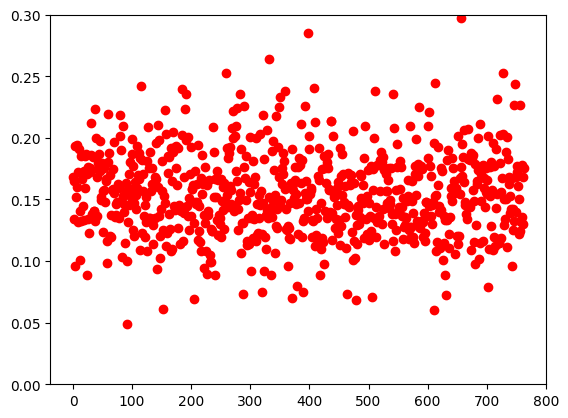

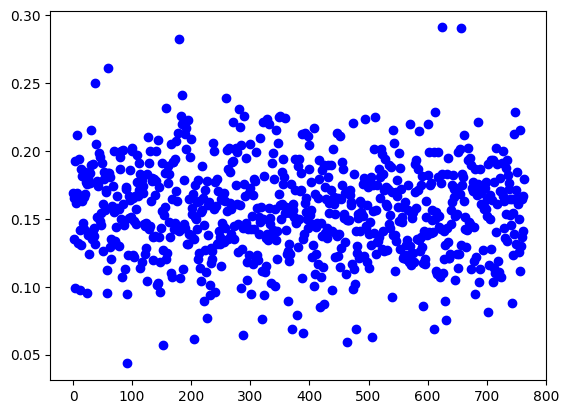

In [65]:
import matplotlib.pyplot as plt
model, epoch_train_loss,y_score,y_test=test(model, device,test_loader, args)

# y_score is in the form of torch tensor. So not converted to numpy properly
x=[i for i in range(len(y_score)-1)]
#print(len(x),y_score[0])
#print(list(y_test[0]))
target=list(y_test[0])
predicted=[]
for i in range(len(y_score[0])):
    predicted.append(y_score[0][i][0])



plt.ylim(0,0.3)
plt.scatter(x=[i for i in range(len(predicted))],y=predicted,color='red',label='Predicted')
plt.show()
plt.scatter(x=[i for i in range(len(predicted))],y=target,color='blue',label='Actual Values')
plt.show()

In [66]:
# converting data to actual boiling points
c=0
for i in target:
    target[c]=target[c]*(max_val-min_val)+min_val
    target[c]=target[c]*std+mean
    c=c+1

c=0
for i in predicted:
    predicted[c]=predicted[c]*(max_val-min_val)+min_val
    predicted[c]=predicted[c]*std+mean
    c=c+1


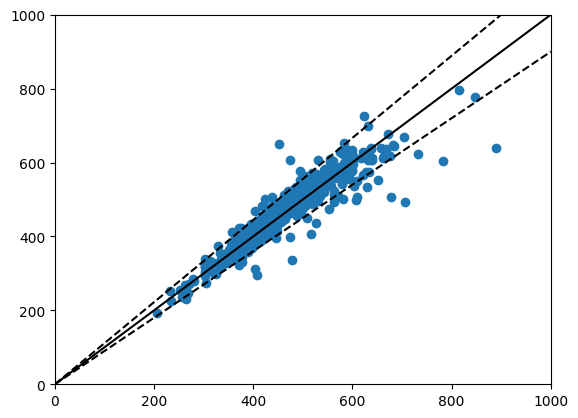

In [67]:
plt.scatter(predicted,target)
plt.plot([0,1000],[0,1000],color='black')
plt.plot([0,900],[0,1000],color='black',linestyle='dashed') # +10 % error
plt.plot([0,1000],[0,900],color='black',linestyle='dashed') # -10 % error
plt.ylim(0,1000)
plt.xlim(0,1000)
plt.show()

In [68]:
# Save test 
test_data= pd.DataFrame()
test_data['GCN Actual Boiling Point']=target
test_data['GCN Predicted Boiling Point']=predicted
test_data.to_csv('../data/Results/GCN_Test_values.csv')


In [69]:
# Train set predictions save
train_loader_pred = DataLoader(train_X, batch_size=len(train_X), shuffle=False, drop_last=True)

In [70]:
import gc

torch.cuda.empty_cache()
gc.collect()

6789

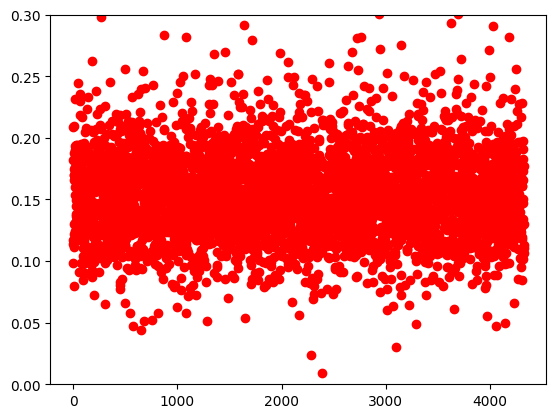

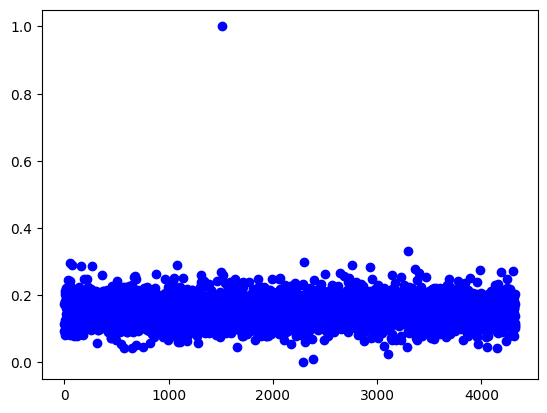

In [71]:
import matplotlib.pyplot as plt
model, epoch_train_loss,y_score,y_test=test(model, device,train_loader_pred, args)

# y_score is in the form of torch tensor. So not converted to numpy properly
x=[i for i in range(len(y_score)-1)]
#print(len(x),y_score[0])
#print(list(y_test[0]))
target=list(y_test[0])
predicted=[]
for i in range(len(y_score[0])):
    predicted.append(y_score[0][i][0])



plt.ylim(0,0.3)
plt.scatter(x=[i for i in range(len(predicted))],y=predicted,color='red',label='Predicted')
plt.show()
plt.scatter(x=[i for i in range(len(predicted))],y=target,color='blue',label='Actual Values')
plt.show()

In [72]:
# converting data to actual boiling points
c=0
for i in target:
    target[c]=target[c]*(max_val-min_val)+min_val
    target[c]=target[c]*std+mean
    c=c+1

c=0
for i in predicted:
    predicted[c]=predicted[c]*(max_val-min_val)+min_val
    predicted[c]=predicted[c]*std+mean
    c=c+1


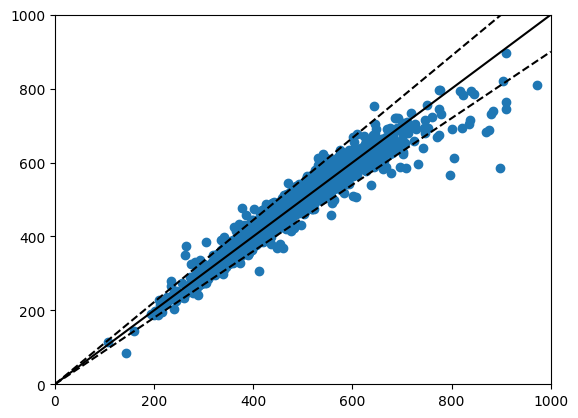

In [73]:
plt.scatter(predicted,target)
plt.plot([0,1000],[0,1000],color='black')
plt.plot([0,900],[0,1000],color='black',linestyle='dashed') # +10 % error
plt.plot([0,1000],[0,900],color='black',linestyle='dashed') # -10 % error
plt.ylim(0,1000)
plt.xlim(0,1000)
plt.show()

In [74]:
# Save train
test_data= pd.DataFrame()
test_data['GCN Actual Boiling Point']=target
test_data['GCN Predicted Boiling Point']=predicted
test_data.to_csv('../data/Results/GCN_Train_values.csv')
